In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


In [ ]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#train['SEASON_2'] = train['SEASON_2'].str.split('-').str[0].astype(int)
#train_filtered = train[train['SEASON_2'] >= 2010]
#test['SEASON_2'] = test['SEASON_2'].str.split('-').str[0].astype(int)
#test_filtered = test[test['SEASON_2'] >= 2010]

In [ ]:
print(test.shape)        # Shape of the test DataFrame


(846253, 25)


In [ ]:
# Step 1: Create cumulative time feature for train and test datasets
def calculate_cumulative_time(df):
    df['QUARTER'] = df['QUARTER'].round()
    df['CUMULATIVE_TIME'] = (df['QUARTER'] - 1) * 720 + df['MINS_LEFT'] * 60 + df['SECS_LEFT']
    return df

train = calculate_cumulative_time(train)
test = calculate_cumulative_time(test)

In [ ]:
print(test.shape)

(846253, 26)


In [ ]:
train_encoded = pd.get_dummies(train['ZONE_ABB'], prefix='ZONE')
test_encoded = pd.get_dummies(test['ZONE_ABB'], prefix='ZONE')

train_combined = pd.concat([train[['SHOT_DISTANCE']], train_encoded], axis=1)
test_combined = pd.concat([test[['SHOT_DISTANCE']], test_encoded], axis=1)


train_impute_data = train[['LOC_X', 'LOC_Y']].join(train_combined, how='left')
test_impute_data = test[['LOC_X', 'LOC_Y']].join(test_combined, how='left')


imputer = KNNImputer(n_neighbors=5)

# Impute missing values for 'LOC_X' and 'LOC_Y' in the training set
#train[['LOC_X', 'LOC_Y']] = imputer.fit_transform(train_impute_data[['LOC_X', 'LOC_Y']])

# Impute missing values for 'LOC_X' and 'LOC_Y' in the test set
test[['LOC_X', 'LOC_Y']] = imputer.fit_transform(test_impute_data[['LOC_X', 'LOC_Y']])



In [ ]:
print(test.isna().sum())

Unnamed: 0             0
SEASON_1               0
SEASON_2               0
TEAM_ID                0
TEAM_NAME              0
PLAYER_ID              0
PLAYER_NAME            0
POSITION_GROUP      1559
POSITION            1559
GAME_DATE          42424
GAME_ID                0
HOME_TEAM              0
AWAY_TEAM              0
ACTION_TYPE            0
SHOT_TYPE              0
BASIC_ZONE             0
ZONE_NAME              0
ZONE_ABB               0
ZONE_RANGE             0
LOC_X                  0
LOC_Y                  0
SHOT_DISTANCE          0
QUARTER                0
MINS_LEFT              0
SECS_LEFT              0
CUMULATIVE_TIME        0
dtype: int64


In [ ]:
from sklearn.preprocessing import MinMaxScaler
features_to_normalize = ['LOC_X', 'LOC_Y', 'CUMULATIVE_TIME']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
train[features_to_normalize] = scaler.fit_transform(train[features_to_normalize])

# Transform the test data using the same scaler
test[features_to_normalize] = scaler.transform(test[features_to_normalize])

# Check the scaled data
print(train[features_to_normalize].head())
print(test[features_to_normalize].head())

      LOC_X     LOC_Y  CUMULATIVE_TIME
0  0.499660  0.061165         0.265113
1       NaN       NaN         0.232289
2  0.078165  0.090812         0.492819
3  0.513644  0.079060         0.060102
4  0.961108  0.035256         0.287996
      LOC_X     LOC_Y  CUMULATIVE_TIME
0  0.467699  0.118803         0.451179
1  0.547603  0.083333         0.091989
2  0.499660  0.320513         0.503698
3  0.479684  0.066239         0.070981
4  0.536416  0.079541         0.450617


In [ ]:

train= train.dropna()
features = features_to_normalize
X = train[features]
y = train['SHOT_MADE']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

df = X

# Find the total number of missing values (NaN) in the dataset
missing_values = df.isna().sum().sum()

# Find the number of missing values for each column
missing_values_per_column = df.isna().sum()

print(f"Total missing values in the dataset: {missing_values}")
print("Missing values per column:")
print(missing_values_per_column)

Total missing values in the dataset: 0
Missing values per column:
LOC_X              0
LOC_Y              0
CUMULATIVE_TIME    0
dtype: int64


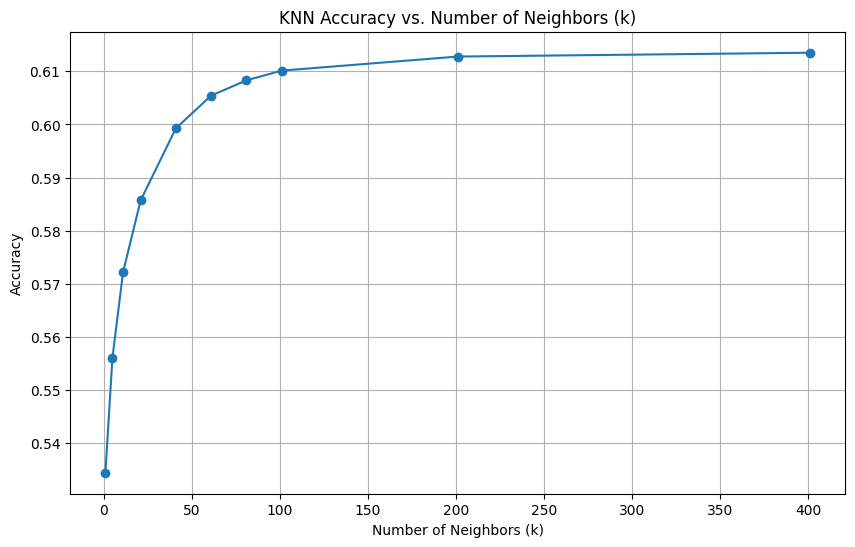

In [ ]:

accuracies = []
k_values = [1,5,11,21,41,61,81,101,201,401]

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
test=test[features]
print(test.shape)

(846253, 3)


In [ ]:
    knn = KNeighborsClassifier(n_neighbors=71)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=71)
knn.fit(X, y)

test['SHOT_MADE'] = knn.predict(test)



In [ ]:
cm=confusion_matrix(y_val,y_pred)
cm

array([[243312,  70479],
       [157196, 108396]])

Text(95.72222222222221, 0.5, 'Truth')

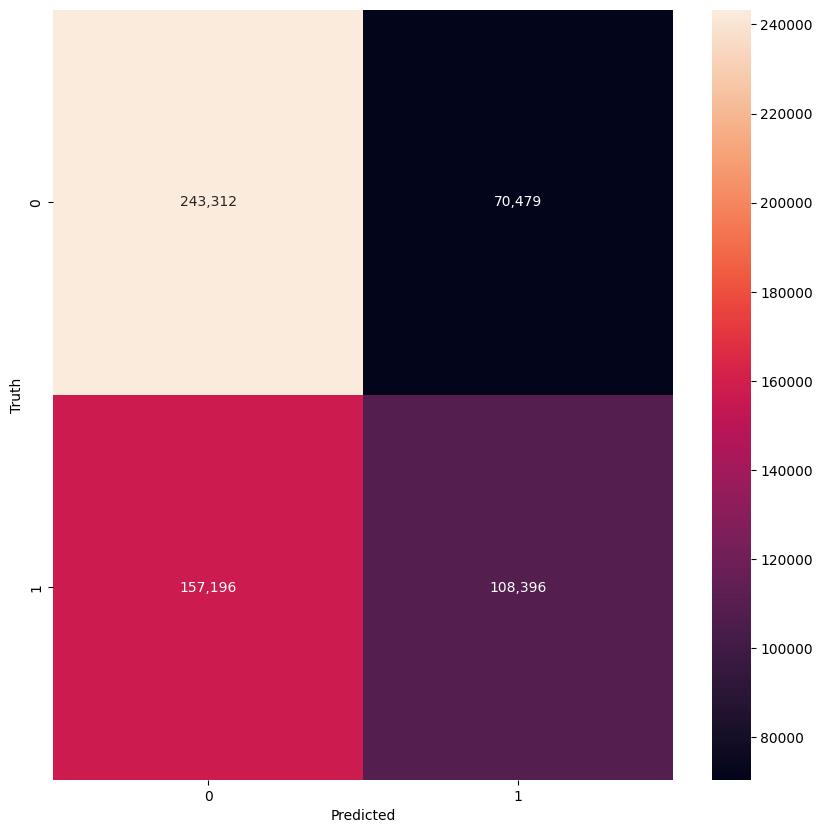

In [ ]:
plt.figure(figsize=(10,10))
sn.heatmap(cm, annot=True, fmt=',d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

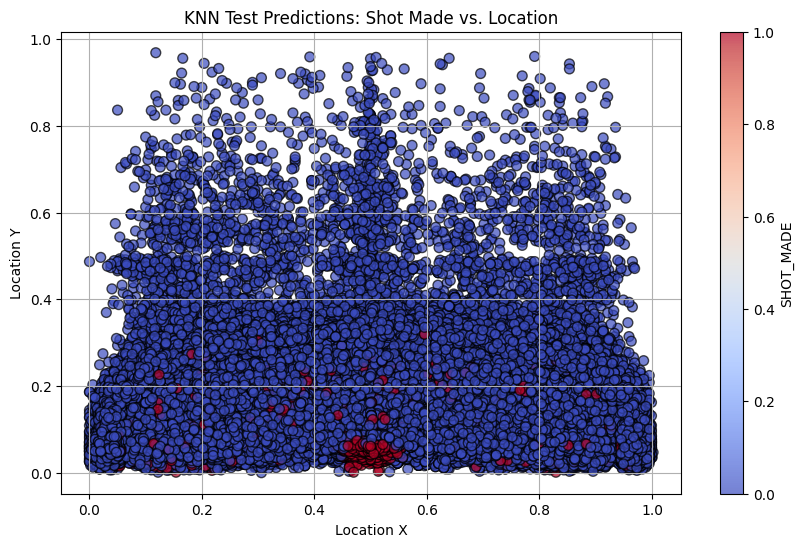

In [ ]:

# Scatter plot for KNN predictions on the test dataset
plt.figure(figsize=(10, 6))
plt.scatter(test['LOC_X'], test['LOC_Y'], c=test['SHOT_MADE'], cmap='coolwarm', s=50, edgecolor='k', alpha=0.7)
plt.colorbar(label='SHOT_MADE')
plt.title('KNN Test Predictions: Shot Made vs. Location')
plt.xlabel('Location X')
plt.ylabel('Location Y')
plt.grid(True)
plt.show()

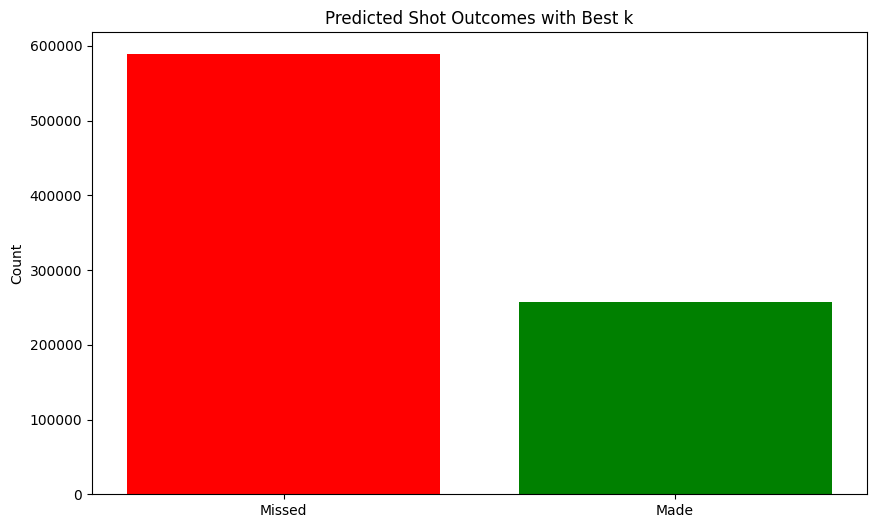

In [ ]:
# Step 7: Add predictions to submission.csv
submission = pd.read_csv('submission.csv')
submission['SHOT_MADE'] = test['SHOT_MADE']
submission.to_csv('submission.csv', index=False)
# Graph results for the best k
plt.figure(figsize=(10, 6))
plt.bar(['Missed', 'Made'], [sum(test['SHOT_MADE'] == 0), sum(test['SHOT_MADE'] == 1)], color=['red', 'green'])
plt.title('Predicted Shot Outcomes with Best k')
plt.ylabel('Count')
plt.show()

In [ ]:
test.head()


,LOC_X,LOC_Y,CUMULATIVE_TIME,SHOT_MADE
0,0.467699,0.118803,0.451179,False
1,0.547603,0.083333,0.091989,False
2,0.499660,0.320513,0.503698,False
3,0.479684,0.066239,0.070981,True
4,0.536416,0.079541,0.450617,False


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

       False       0.61      0.78      0.68    313791
        True       0.61      0.41      0.49    265592

    accuracy                           0.61    579383
   macro avg       0.61      0.59      0.58    579383
weighted avg       0.61      0.61      0.59    579383



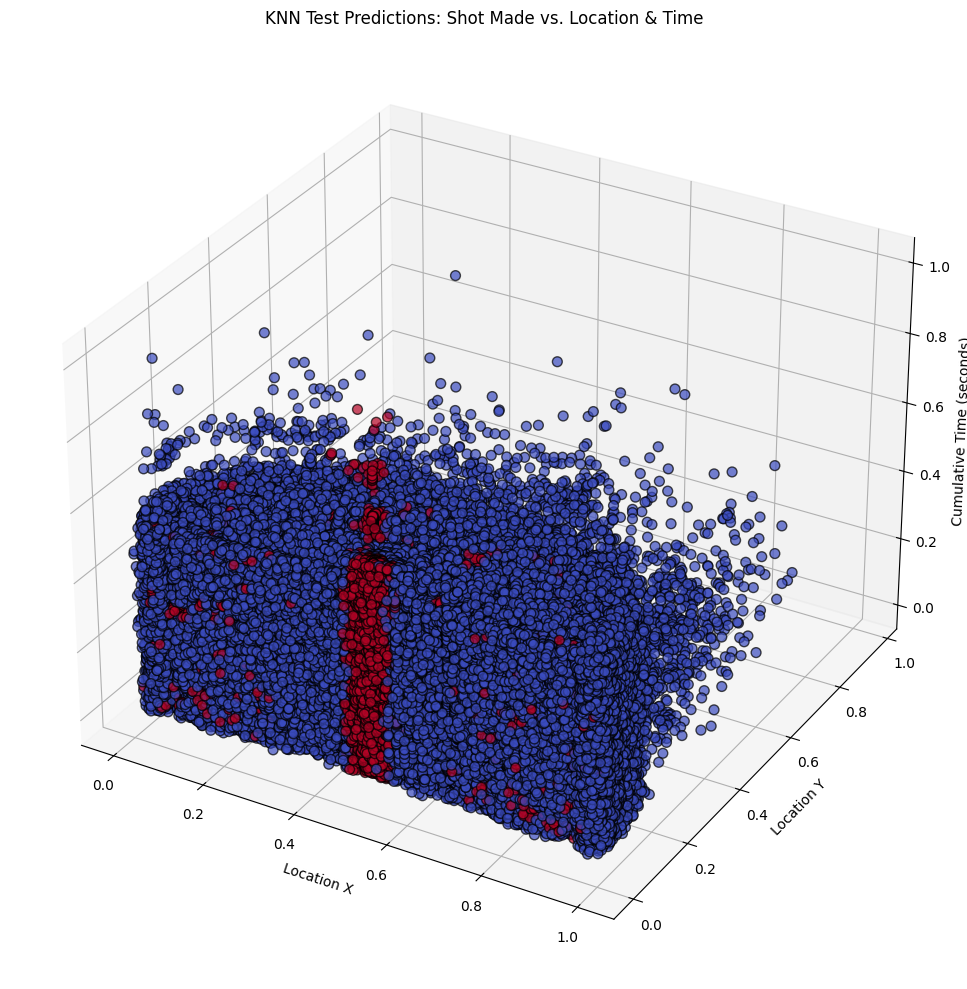

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(test['LOC_X'], test['LOC_Y'],test['CUMULATIVE_TIME'], c=test['SHOT_MADE'], cmap='coolwarm', s=50, edgecolor='k', alpha=0.7)


# Labels and title
ax.set_xlabel('Location X')
ax.set_ylabel('Location Y')
ax.set_zlabel('Cumulative Time (seconds)')
ax.set_title('KNN Test Predictions: Shot Made vs. Location & Time')
plt.tight_layout()
# Show plot
plt.show()

<ipython-input-26-63f621b4ec85>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
<ipython-input-26-63f621b4ec85>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
<ipython-input-26-63f621b4ec85>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Class Distribution:
Made Shots: 782552 (37.28%)
Missed Shots: 1316598 (62.72%)
Total Shots: 2099150
Cross-Validation Accuracy Scores: [0.56587798 0.56474145 0.56538585 0.54092597 0.54138548]
Mean CV Accuracy: 0.5556633477076344

Validation Set Evaluation Metrics:
Accuracy: 0.608
Precision: 0.466
Recall: 0.377
F1 Score: 0.417

Test Set Evaluation Metrics:
Accuracy: 0.606
Precision: 0.464
Recall: 0.379
F1 Score: 0.417


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


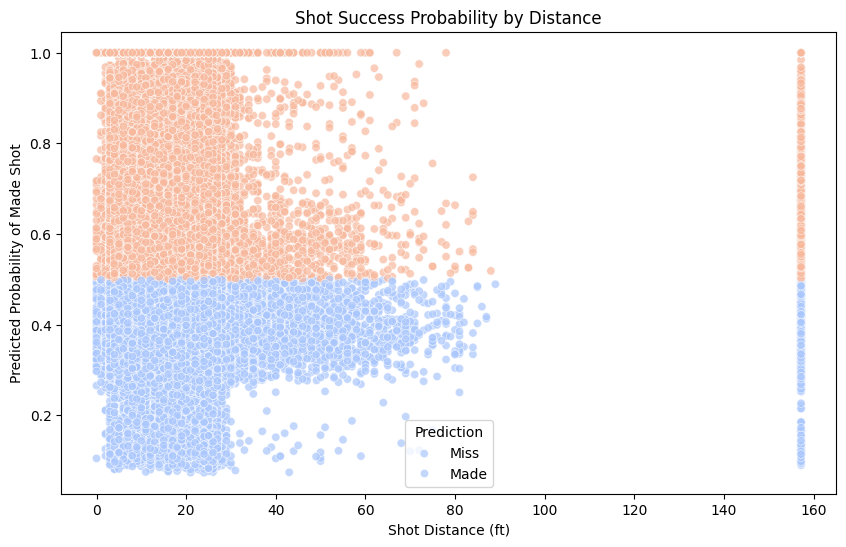

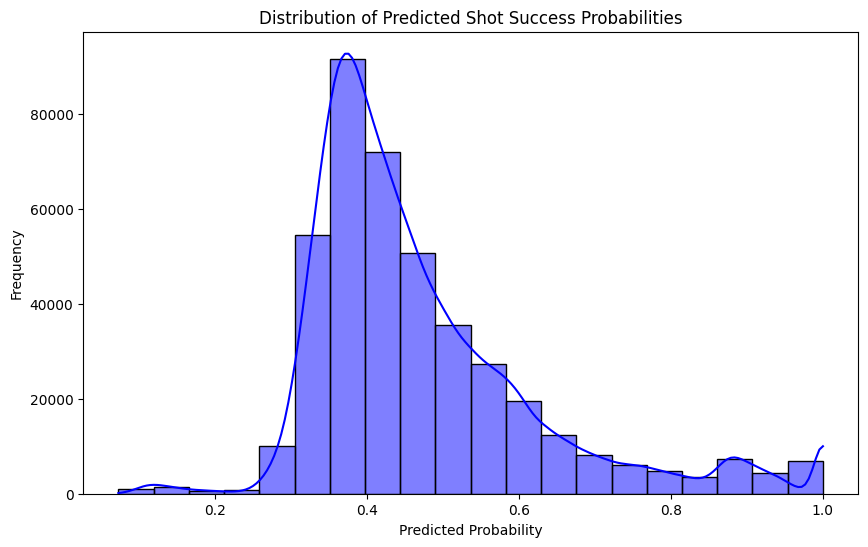

<ipython-input-26-63f621b4ec85>:189: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=test_df['BASIC_ZONE'], y=test_df['Predicted_Probability_Made'], palette='Set3')


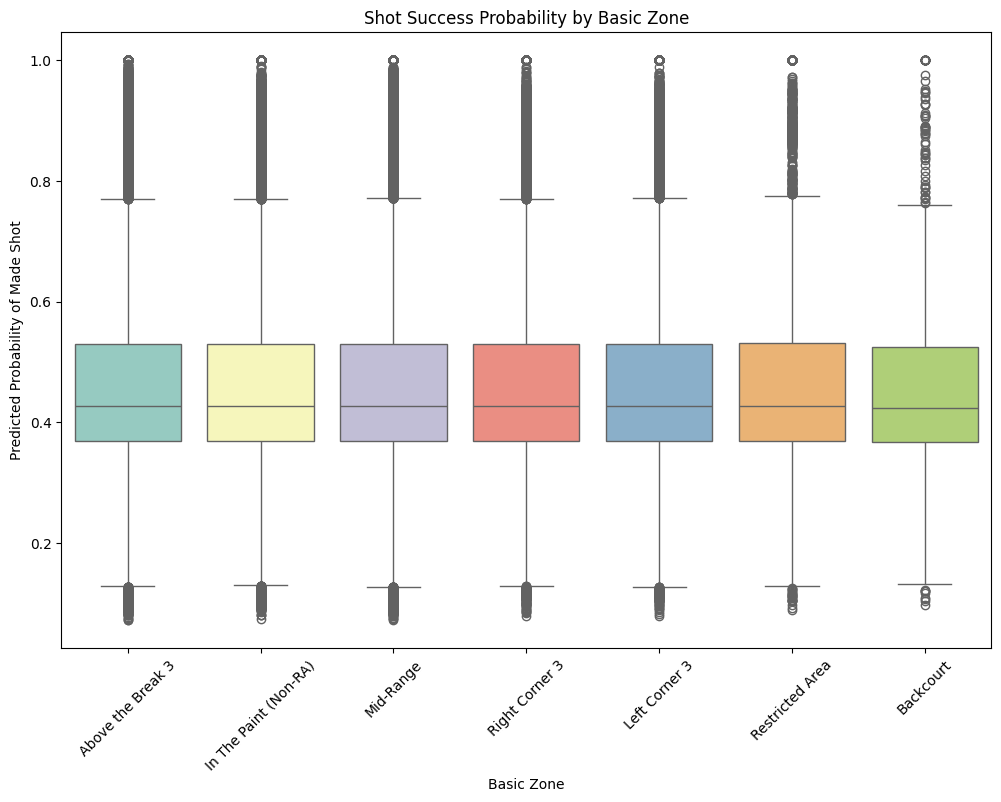

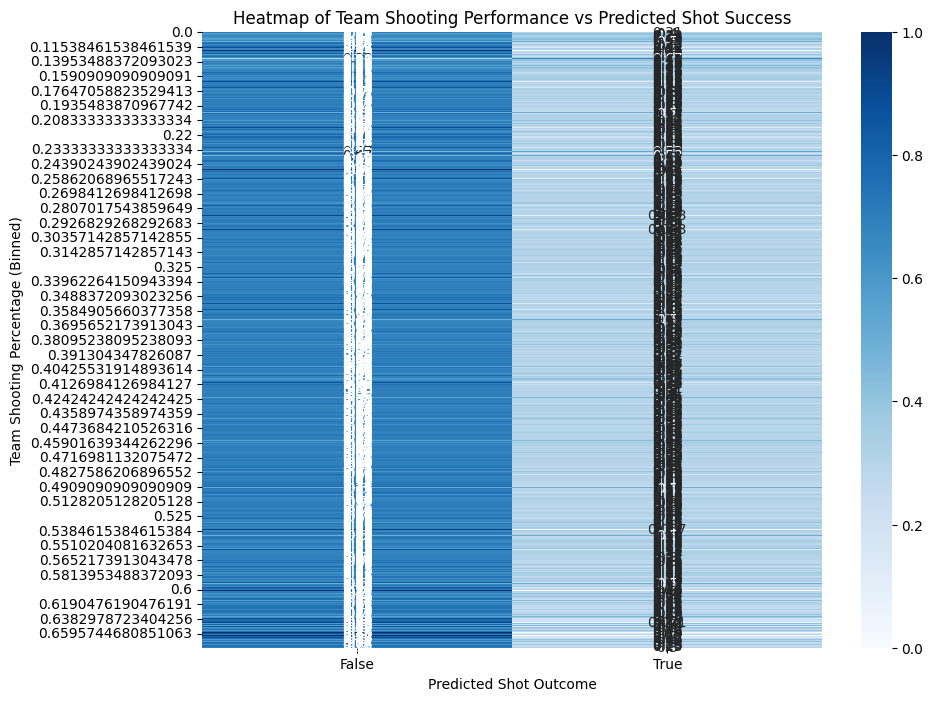

<ipython-input-26-63f621b4ec85>:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=test_df['POSITION'], y=test_df['Predicted_Probability_Made'], palette='muted')


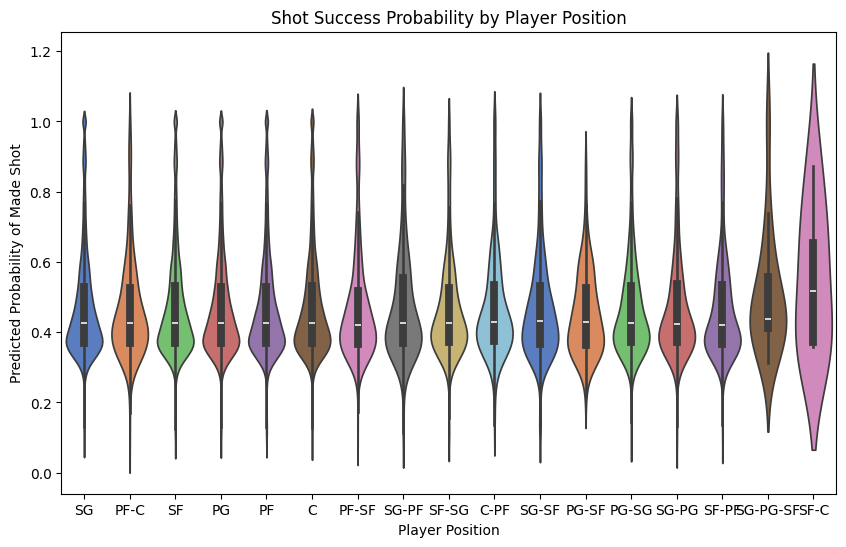

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt

data_df = pd.read_csv("train.csv")


# Filter for two types of shots only: jump shot and 3PT shot
valid_shots = [
    'Jump Shot', 'Pullup Jump shot', 'Step Back Jump shot', 'Turnaround Jump Shot',
    'Fadeaway Jump Shot', 'Running Jump Shot', 'Floating Jump shot',
    'Turnaround Fadeaway shot', 'Running Pull-Up Jump Shot'
]
data_df = data_df[data_df['ACTION_TYPE'].isin(valid_shots)]

### a function to compute teammates shooting perfomance
### for every game. we will use the result to gauge impact
### on individual perfomance.

def add_teammate_performance(df):

    # total shots attempted and made by teammates
    df['TEAM_SHOTS_MADE'] = df.groupby(['GAME_ID', 'TEAM_ID'])['SHOT_MADE'].transform('sum')
    df['TEAM_TOTAL_SHOTS'] = df.groupby(['GAME_ID', 'TEAM_ID'])['SHOT_MADE'].transform('count')
    df['TEAM_SHOOTING_PERCENTAGE'] = df['TEAM_SHOTS_MADE'] / df['TEAM_TOTAL_SHOTS']
    df['TEAM_SHOOTING_PERCENTAGE'] = df['TEAM_SHOOTING_PERCENTAGE'].fillna(0)
    return df

# add teammate performance metrics to dataframe
data_df = add_teammate_performance(data_df)



#3 types of variables - a)defensive zone schemes b) time left + distnace c) team perfomance
variables_kept = ['SEASON_1', 'MINS_LEFT', 'ACTION_TYPE', 'SHOT_TYPE',
                     'BASIC_ZONE', 'ZONE_NAME', 'SHOT_DISTANCE', 'SECS_LEFT',
                     'QUARTER', 'POSITION', 'TEAM_SHOOTING_PERCENTAGE']

data_df = data_df[variables_kept + ['SHOT_MADE']]


def preprocess_data(df, is_train=True):
    # Drop rows with missing data
    df = df.dropna(subset=['SEASON_1', 'MINS_LEFT', 'ACTION_TYPE', 'SHOT_TYPE',
                           'BASIC_ZONE', 'ZONE_NAME', 'SHOT_DISTANCE', 'SECS_LEFT',
                           'QUARTER', 'POSITION', 'TEAM_SHOOTING_PERCENTAGE'])
    #print(f"Data after dropping NaNs: {df.shape}")  # Debugging

    # hotone encode cat vars
    label_encoders = {}
    for col in ['ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'QUARTER', 'POSITION']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # features and target
    features = ['SEASON_1', 'MINS_LEFT', 'ACTION_TYPE', 'BASIC_ZONE',
                'ZONE_NAME', 'SHOT_DISTANCE', 'SECS_LEFT',
                'QUARTER', 'POSITION', 'TEAM_SHOOTING_PERCENTAGE']
    if is_train:
        if 'SHOT_MADE' not in df.columns or df.empty:
            #print("Training data is empty or 'SHOT_MADE' column is missing.")  # Debugging
            return None, None, None
        target = 'SHOT_MADE'
        X = df[features]
        y = df[target]
        return X, y, label_encoders
    else:
        if df.empty:
            #print("Test data is empty.")  # Debugging
            return None, None
        X = df[features]
        return X, label_encoders

# Preprocess data
X, y, label_encoders = preprocess_data(data_df)

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)


#this tells us some imbalance in data
#we will apply SMOTE to balance

class_balance = data_df['SHOT_MADE'].value_counts()
total_shots = class_balance.sum()

# check presence of both classes (1 = Made, 0 = Missed)
made_count = class_balance.get(1, 0)
missed_count = class_balance.get(0, 0)

# Calc %
made_percentage = (made_count / total_shots) * 100 if total_shots > 0 else 0
missed_percentage = (missed_count / total_shots) * 100 if total_shots > 0 else 0

# Print results
print("Class Distribution:")
print(f"Made Shots: {made_count} ({made_percentage:.2f}%)")
print(f"Missed Shots: {missed_count} ({missed_percentage:.2f}%)")
print(f"Total Shots: {total_shots}")

# Apply SMOTE to the training data, to get some balance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train Naive Bayes model
nb_classifier = GaussianNB()
cv_scores = cross_val_score(nb_classifier, X_train_scaled, y_train_balanced, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", cv_scores)

print("Mean CV Accuracy:", cv_scores.mean())

# Train final model on training set
nb_classifier.fit(X_train_scaled, y_train_balanced)

# Evaluate on validation set
y_val_pred = nb_classifier.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("\nValidation Set Evaluation Metrics:")
print(f"Accuracy: {val_accuracy:.3f}")
print(f"Precision: {val_precision:.3f}")
print(f"Recall: {val_recall:.3f}")
print(f"F1 Score: {val_f1:.3f}")

# Evaluate on test set
test_probs = nb_classifier.predict_proba(X_test_scaled)[:, 1]
test_predictions = nb_classifier.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)


print("\nTest Set Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1 Score: {test_f1:.3f}")

# Add predictions to test data
test_indices = data_df.index[len(X_train) + len(X_val):len(X_train) +
                             len(X_val) + len(X_test)]  # Exact test indices
test_df = data_df.loc[test_indices].copy()  # Correct test DataFrame based on split indices
test_df['Predicted_Probability_Made'] = test_probs
test_df['Predicted_Shot_Made'] = test_predictions

# Save the test data with predictions
test_df.to_csv("test_with_predictions_position_teammates.csv", index=False)


# Visualization 1: Probability of shot success by shot distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_df['SHOT_DISTANCE'], y=test_df['Predicted_Probability_Made'], hue=test_df['Predicted_Shot_Made'], palette='coolwarm', alpha=0.7)
plt.title('Shot Success Probability by Distance')
plt.xlabel('Shot Distance (ft)')
plt.ylabel('Predicted Probability of Made Shot')
plt.legend(title='Prediction', labels=['Miss', 'Made'])
plt.show()


# Visualization 2: Distribution of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(test_df['Predicted_Probability_Made'], bins=20, kde=True, color='blue')
plt.title('Distribution of Predicted Shot Success Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

# Visualization 3: Predicted probabilities by shot zone
plt.figure(figsize=(12, 8))
sns.boxplot(x=test_df['BASIC_ZONE'], y=test_df['Predicted_Probability_Made'], palette='Set3')
plt.title('Shot Success Probability by Basic Zone')
plt.xlabel('Basic Zone')
plt.ylabel('Predicted Probability of Made Shot')
plt.xticks(rotation=45)
plt.show()


# Visualization 4: Heatmap of TEAM_SHOOTING_PERCENTAGE vs. Predicted Shot Success
plt.figure(figsize=(10, 8))
sns.heatmap(pd.crosstab(test_df['TEAM_SHOOTING_PERCENTAGE'], test_df['Predicted_Shot_Made'], normalize='index'), cmap='Blues', annot=True, cbar=True)
plt.title('Heatmap of Team Shooting Performance vs Predicted Shot Success')
plt.xlabel('Predicted Shot Outcome')
plt.ylabel('Team Shooting Percentage (Binned)')
plt.show()

# Visualization 5: Shot success probability by position
plt.figure(figsize=(10, 6))
sns.violinplot(x=test_df['POSITION'], y=test_df['Predicted_Probability_Made'], palette='muted')
plt.title('Shot Success Probability by Player Position')
plt.xlabel('Player Position')
plt.ylabel('Predicted Probability of Made Shot')
plt.show()

In [ ]:
test['SHOT_MADE'] = nb_classifier.predict(test)

#Add predictions to submission.csv
submission = pd.read_csv('submission.csv')
submission['SHOT_MADE'] = test['SHOT_MADE']
submission.to_csv('submission.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


ValueError: X has 4 features, but GaussianNB is expecting 10 features as input.